# 1. Build an investment portfolio (valued at 10 000€ or more) composed of 2 different assets

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

We consider a portfolio initially worth USD10,000, equally invested 50/50 in ExxonMobil (XOM) and Chevron (CVX) stocks. This means USD5,000 allocated to each stock at the start of 2024, corresponding to a fixed number of shares for each. We chose 2024-01-01 to 2024-12-31 to avoid Trump presidency consequences.

We compute returns for each trading day of 2024 using publicly available daily adjusted close prices. The daily volatility (standard deviation) of returns over 2024 for this portfolio is on the order of ~1.5–2.0%. This reflects moderate risk: on an average day the portfolio’s value fluctuates within a couple of percent. We will then use these daily returns to estimate the 1-day 1% Value at Risk (VaR) by various methods.

In [67]:
start_date = '2024-01-01'
end_date = '2024-12-31'
stocks = ['XOM', 'CVX']
data = yf.download(stocks, start=start_date, end=end_date, auto_adjust=True)['Close']
data.dropna(inplace=True)

initial_investment = 10000
weights = np.array([0.5, 0.5])
returns = data.pct_change().dropna()
returns['Portfolio'] = returns.dot(weights)

portfolio_value = [initial_investment]
for r in returns['Portfolio']:
    portfolio_value.append(portfolio_value[-1] * (1 + r))
portfolio_value = pd.Series(portfolio_value[1:], index=returns.index)


[*********************100%***********************]  2 of 2 completed


In [68]:
# Compute daily return volatility for CVX and XOM using the 'returns' DataFrame
vol_cvx = returns['CVX'].std()
vol_xom = returns['XOM'].std()

print(f"CVX Daily Volatility: {vol_cvx:.4%}")
print(f"XOM Daily Volatility: {vol_xom:.4%}")



# Compute covariance matrix for the daily returns of CVX and XOM
cov_matrix = returns[['CVX', 'XOM']].cov()
cov_value = cov_matrix.loc['CVX', 'XOM']
print("\nCovariance Matrix:")
print(cov_matrix)
print(F"Covariance between CVX and XOM: {cov_value:.4%}")

CVX Daily Volatility: 1.2134%
XOM Daily Volatility: 1.2033%

Covariance Matrix:
Ticker       CVX       XOM
Ticker                    
CVX     0.000147  0.000106
XOM     0.000106  0.000145
Covariance between CVX and XOM: 0.0106%


In [69]:
w1 = w2 = 0.5

portfolio_volatility = np.sqrt((w1**2)*(vol_xom**2) + (w2**2)*(vol_cvx**2) + 2*w1*w2*cov_value)
print(f"Portfolio volatility: {portfolio_volatility:.4%}")

Portfolio volatility: 1.1220%


# 2. For each of the approaches below, (i) calculate the daily VaR (1%) in € of your portfolio, (ii) explain the methodology, (iii) plot the result, (iv) comment the result, (v) compare the results of the different approaches.


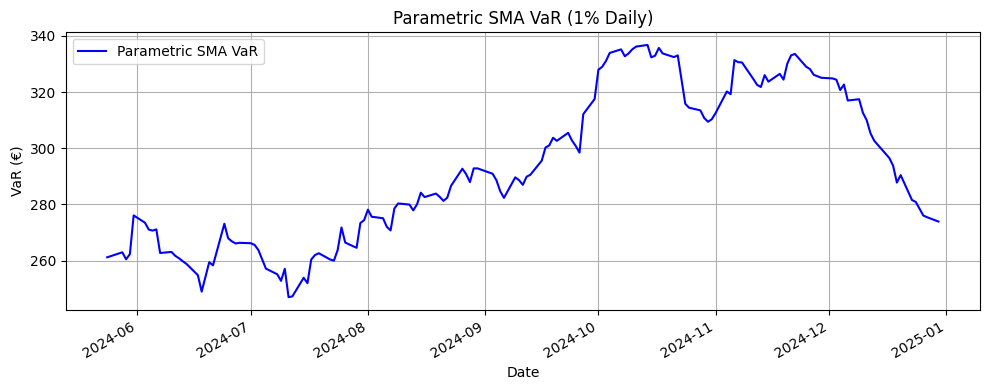

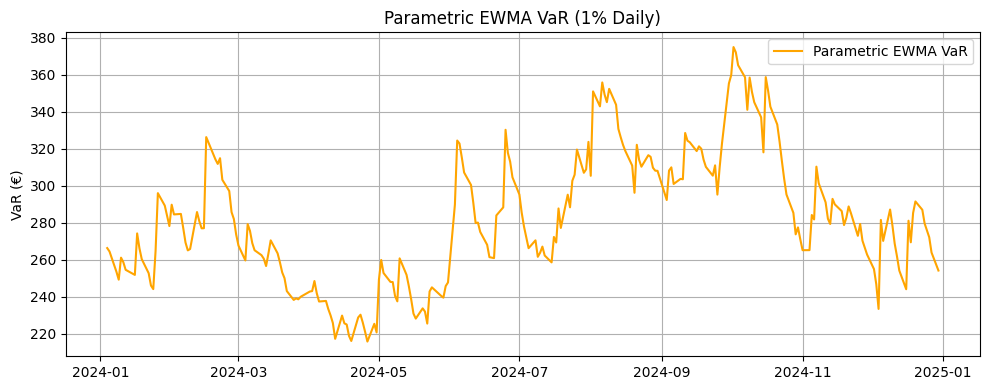

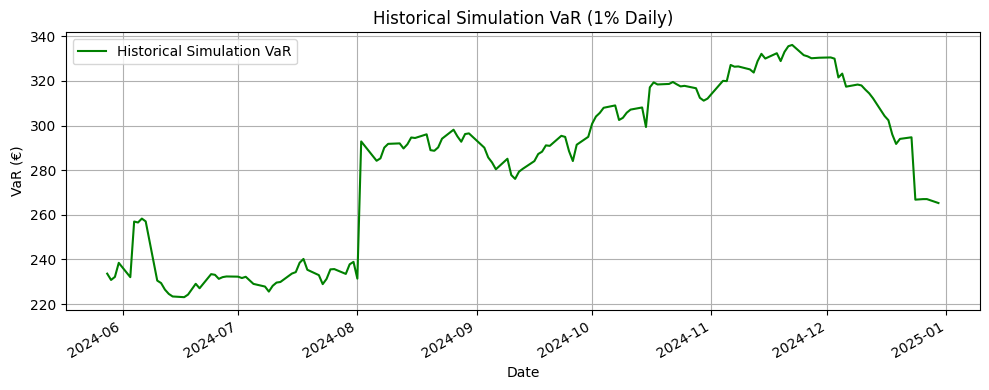

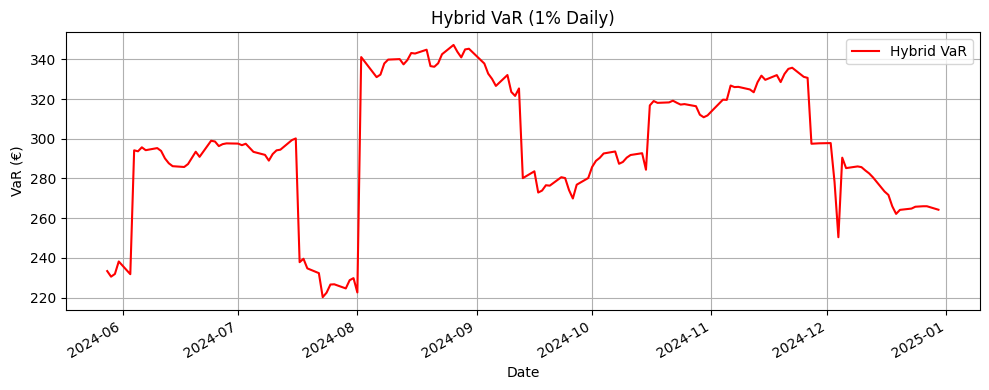

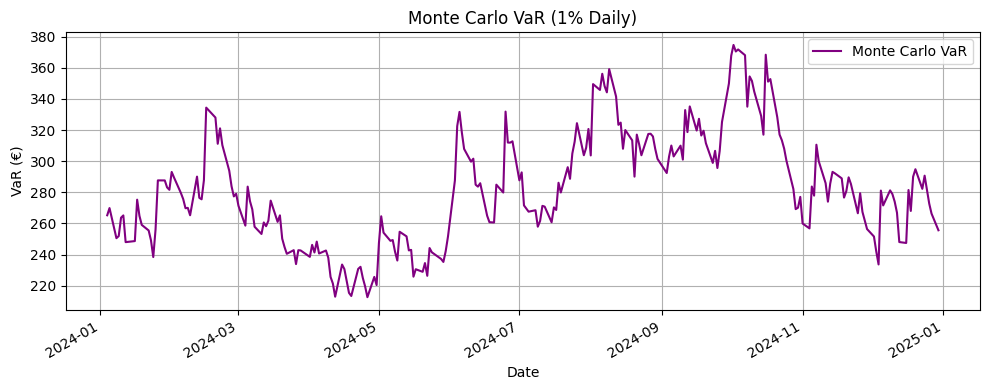

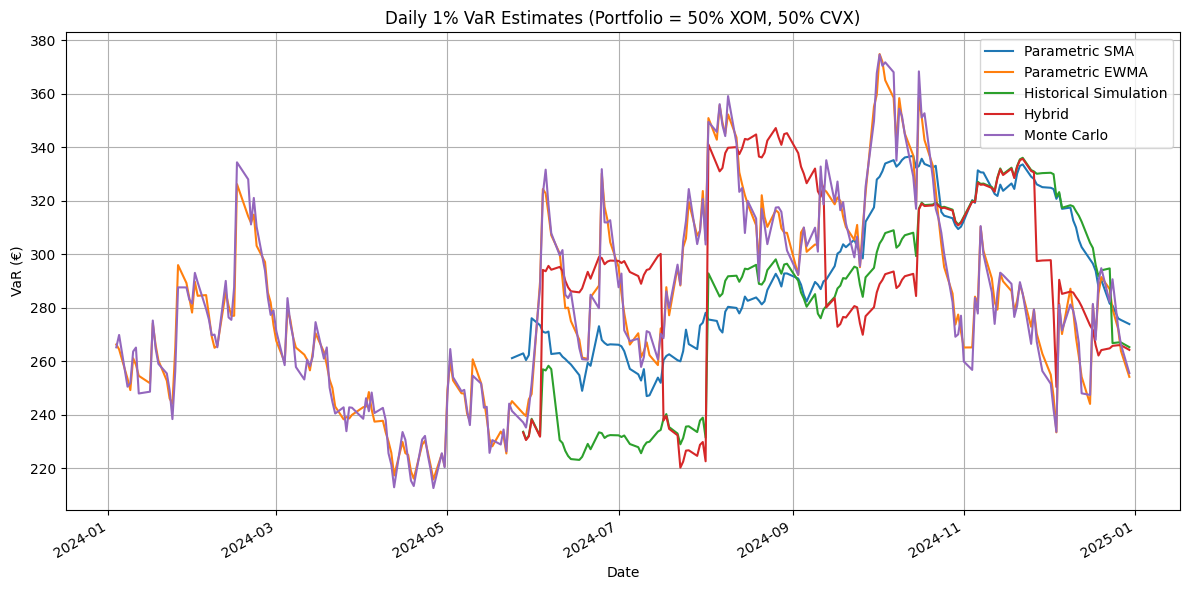

In [70]:
window = 100
z_1pct = 2.33

# Parametric SMA VaR
sma_vol = returns['Portfolio'].rolling(window).std()
var_sma = z_1pct * sma_vol * portfolio_value

plt.figure(figsize=(10,4))
var_sma.dropna().plot(color='blue', label='Parametric SMA VaR')
plt.title('Parametric SMA VaR (1% Daily)')
plt.ylabel('VaR (€)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Parametric EWMA VaR
lmbda = 0.94
ewma_vol = np.zeros(len(returns))
ewma_vol[0] = returns['Portfolio'].std()
for t in range(1, len(returns)):
    ewma_vol[t] = np.sqrt(lmbda * ewma_vol[t-1]**2 + (1 - lmbda) * returns['Portfolio'].iloc[t-1]**2)
var_ewma = z_1pct * ewma_vol * portfolio_value.values

plt.figure(figsize=(10,4))
plt.plot(returns.index[1:], var_ewma[1:], color='orange', label='Parametric EWMA VaR')
plt.title('Parametric EWMA VaR (1% Daily)')
plt.ylabel('VaR (€)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Historical Simulation VaR
hs_var = []
for t in range(window, len(returns)):
    sample = returns['Portfolio'].iloc[t-window:t]
    var = -np.percentile(sample, 1) * portfolio_value.iloc[t]
    hs_var.append(var)
hs_var = pd.Series(hs_var, index=returns.index[window:])

plt.figure(figsize=(10,4))
hs_var.plot(color='green', label='Historical Simulation VaR')
plt.title('Historical Simulation VaR (1% Daily)')
plt.ylabel('VaR (€)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Hybrid EWMA-weighted Historical VaR
hybrid_var = []

for t in range(window, len(returns)):
    # Get windowed returns (unsorted)
    sample_returns = returns['Portfolio'].iloc[t-window:t].values
    port_val = portfolio_value.iloc[t]

    # Apply exponential weights (most recent = highest weight)
    weights = np.array([(lmbda**i) * (1 - lmbda) for i in range(window)])
    weights = weights[::-1]  # most recent first
    weights /= weights.sum()

    # Combine returns and weights, then sort by return value (ascending)
    combined = list(zip(sample_returns, weights))
    combined.sort(key=lambda x: x[0])  # sort by return (losses first)

    # Accumulate weights until 1% threshold is passed
    cum_weight = 0
    for r, w in combined:
        cum_weight += w
        if cum_weight >= 0.01:
            var = -r * port_val  # Convert to positive euro VaR
            hybrid_var.append(var)
            break

# Convert to series
hybrid_var = pd.Series(hybrid_var, index=returns.index[window:])

# Plot
plt.figure(figsize=(10, 4))
hybrid_var.plot(color='red', label='Hybrid VaR')
plt.title('Hybrid VaR (1% Daily)')
plt.ylabel('VaR (€)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Monte Carlo Simulation VaR
mc_var_values = []  # Use plain list here
n_sim = 10000
np.random.seed(42)

ewma_series = pd.Series(ewma_vol, index=returns.index)

for t in range(1, len(returns)):
    current_date = returns.index[t]
    sigma = ewma_series.iloc[t]
    port_val = portfolio_value.iloc[t]

    if sigma <= 0 or np.isnan(sigma):
        mc_var_values.append(np.nan)
        continue

    # Simulate returns
    simulated_returns = np.random.normal(0, sigma, n_sim)

    # Convert to euro losses
    losses = -simulated_returns * port_val

    # Get 1% percentile VaR (positive)
    var = np.percentile(losses, 99)
    mc_var_values.append(var)

# Convert to Series after loop
mc_var = pd.Series(mc_var_values, index=returns.index[1:])

# Align index
mc_var = pd.Series(mc_var, index=returns.index[1:])

plt.figure(figsize=(10,4))
mc_var.plot(color='purple', label='Monte Carlo VaR')
plt.title('Monte Carlo VaR (1% Daily)')
plt.ylabel('VaR (€)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Combined Plot
plt.figure(figsize=(12,6))
var_sma.dropna().plot(label='Parametric SMA')
plt.plot(returns.index[1:], var_ewma[1:], label='Parametric EWMA')
hs_var.plot(label='Historical Simulation')
hybrid_var.plot(label='Hybrid')
mc_var.plot(label='Monte Carlo')
plt.title('Daily 1% VaR Estimates (Portfolio = 50% XOM, 50% CVX)')
plt.ylabel('VaR (€)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Methodology & Results:**

---



**a) Parametric VaR using SMA**
This method assumes that daily portfolio returns are normally distributed. It estimates volatility using a Simple Moving Average (SMA) over a fixed number of days (e.g. 100), giving equal weight to all past returns in the window. The VaR is then determined by applying the standard deviation (volatility) and a z-score corresponding to the desired confidence level (e.g. 1%) to the current portfolio value.

**Result:** This method produces a VaR that changes relatively slowly over time, since each volatility estimate equally reflects 100 days of data. When market volatility rises suddenly, the SMA-volatility (and VaR) increases but only after enough high-volatility days enter the window. Conversely, it may remain elevated for a while after volatility falls. In the figure, the blue line represents the 99% 1-day VaR via the parametric SMA method.

**b) Parametric VaR using EWMA**
This is also based on the assumption of normally distributed returns, but instead of SMA, it uses an Exponentially Weighted Moving Average (EWMA) to estimate volatility. Recent returns are given more weight than older ones, making this method more responsive to recent changes in market volatility. The EWMA uses a decay factor (λ) to control how quickly weights decrease over time. We use a delta of 0.94 because we found a paper (https://www.msci.com/documents/10199/5915b101-4206-4ba0-aee2-3449d5c7e95a) that it gaves the best out‑of‑sample daily‑volatility and covariance forecasts across more than 480 time‑series.

**Result:** The EWMA-based VaR (orange line) is more responsive to volatility shifts than the SMA VaR. After a volatility spike, EWMA VaR jumps quickly (since recent €r_{p,t}^2€ terms get high weight), and during calm periods it decays gradually. Overall, the EWMA VaR tends to be a smoother but more reactive estimate of risk than the SMA VaR. It captures volatility clustering effectively – large moves in the portfolio immediately raise €\sigma_t€ and thus VaR.

**c) Non-Parametric VaR (Historical Simulation)**
This method does not assume any specific distribution. Instead, it uses actual historical returns of the portfolio over a lookback window (e.g. 100 days). The returns are sorted, and the VaR is taken as the worst 1% return in that dataset. It fully relies on the historical behavior of the portfolio and reflects real market movements during that period.

**Result:** The HS VaR directly reflects actual losses observed. If a new extreme loss occurs, VaR immediately spikes to that loss level. Conversely, if extreme past days roll out of the window, VaR can drop abruptly. For our portfolio, HS VaR tends to be lower than the parametric VaR during tranquil periods (since actual 1% worst losses were milder than the normal-theory predicts), but during turbulent periods HS VaR can exceed the parametric if an outlier return is worse than the normal estimate. It is a more jagged series because it changes only when the worst day in the window changes.

**d) Hybrid VaR**
This is a blend of historical simulation and EWMA. Like the historical method, it uses past returns, but applies exponentially decreasing weights (like EWMA) to emphasize more recent data. The 1% tail of the weighted distribution is then used to estimate VaR. This allows the method to better reflect both recent volatility and empirical return distributions.

**Result:** The hybrid VaR lies between pure historical and pure EWMA methods. It adjusts quicker to recent volatility than equal-weight HS. For example, if volatility rises, the worst recent losses get big weight and VaR moves up faster than HS VaR. In mid-2024 (in our analysis), the hybrid VaR spiked sooner than the unweighted HS VaR when the portfolio experienced a cluster of larger losses. Overall, the hybrid method provides a compromise – sensitivity to new shocks without discarding older data entirely.

**e) Monte Carlo Simulation VaR**
This method simulates a large number of potential future portfolio returns using a stochastic process, typically assuming a normal distribution with estimated volatility. Each simulation produces a potential profit or loss. The simulated losses are ranked, and the 1st percentile loss is selected as the VaR. This method is very flexible and can be extended to incorporate non-normal distributions or complex instruments.

**Result:** In our case, with a normal model, the MC VaR closely tracks the parametric EWMA VaR. There is very little difference between simulating 10k normals versus using the €z_{0.01}€ formula, which validates the parametric result. MC becomes more powerful if we had, for example, options in the portfolio (nonlinear payoffs) or wanted to model fat-tailed returns – we could simulate from a t-distribution or historical return resampling, etc. Here it mostly serves as a consistency check.

**Overall comparison:**


---


All methods show the portfolio’s 1% daily VaR in 2024 ranged roughly from USD220 to USD370. The most conservative (highest) estimates at peaks came from the EWMA-normal and Monte Carlo methods (e.g. hitting USD370 in one volatile spell), since the normal assumption with fresh volatility can anticipate more extreme moves than have occurred.  The Parametric SMA (blue) is the smoothest, reflecting its lag in adapting to market shifts due to equal weighting of past returns. The Parametric EWMA (orange) and Monte Carlo (purple) closely align, as both assume normality and use EWMA volatility; they respond rapidly to volatility changes. The Historical Simulation (green) is purely empirical, showing abrupt changes when new extreme losses enter the rolling window, while the Hybrid method (red) balances realism and responsiveness by applying EWMA-style weights to historical data. Among these, the Hybrid VaR offers a strong trade-off between sensitivity and robustness.

# 3. For the parametric approach using SMA, (i) calculate the weekly, monthly and annual VaR (1%) and (ii) convert the VaR (1%) to VaR (10%).


In [71]:
final_sigma = sma_vol.dropna().iloc[-1]
VaR_1d = z_1pct * final_sigma * initial_investment
VaR_week = VaR_1d * np.sqrt(5)
VaR_month = VaR_1d * np.sqrt(21)
VaR_year = VaR_1d * np.sqrt(252)
VaR_10pct = VaR_1d * (1.28 / z_1pct)  # z_10pct = 1.28

print("--- Question 3: VaR Scaling (Parametric SMA) ---")
print(f"1-day 1% VaR: €{VaR_1d:.2f}")
print(f"1-week 1% VaR: €{VaR_week:.2f}")
print(f"1-month 1% VaR: €{VaR_month:.2f}")
print(f"1-year 1% VaR: €{VaR_year:.2f}")
print(f"1-day 10% VaR: €{VaR_10pct:.2f}")


--- Question 3: VaR Scaling (Parametric SMA) ---
1-day 1% VaR: €264.54
1-week 1% VaR: €591.54
1-month 1% VaR: €1212.29
1-year 1% VaR: €4199.50
1-day 10% VaR: €145.33


# 4. For the non-parametric approach, (i) calculate a Stressed VaR (1%) in € of your investment portfolio based on a time series of one year during stressed economic conditions (select any crisis period of your choice), (ii) compare the non-parametric Stressed VaR to the non-parametric VaR estimated in 2. c), (iii) interpret your results.


In [72]:
# Stressed VaR (2020 COVID Crash):
weights = np.array([0.5, 0.5])

# 2020 COVID crash period
crisis_start = '2020-01-01'
crisis_end = '2020-12-31'
data_2020 = yf.download(stocks, start=crisis_start, end=crisis_end, auto_adjust=True)['Close']
data_2020.dropna(inplace=True)
returns_2020 = data_2020.pct_change().dropna()
returns_2020['Portfolio'] = returns_2020.dot(weights)

# Stressed Historical VaR
stressed_var = -np.percentile(returns_2020['Portfolio'], 1) * initial_investment

print("\n--- Question 4: Stressed VaR (2020) ---")
print(f"Stressed 1-day 1% VaR: €{stressed_var:.2f}")
print(f"2024 Historical VaR (Last Value): €{hs_var.iloc[-1]:.2f}")
print(f"Ratio (Stressed / Normal): {stressed_var / hs_var.iloc[-1]:.2f}x")

[*********************100%***********************]  2 of 2 completed


--- Question 4: Stressed VaR (2020) ---
Stressed 1-day 1% VaR: €1138.93
2024 Historical VaR (Last Value): €265.28
Ratio (Stressed / Normal): 4.29x


**Interpretation:**


---


The 1% stressed VaR (COVID-crisis) being say USD1,128 vs USD265 in 2024 means that if a shock of 2020 magnitude hit our current portfolio, the losses could be about more than 4 times greater than what 2024-based models anticipate. This highlights why relying solely on recent calm period data can understate risk – one must consider stress scenarios. Financial institutions therefore compute a “Stressed VaR” using a historical window of turmoil (like 2008 or 2020) to ensure they hold enough capital for such worst-case losses. In our case, the stressed 1-day 1% VaR indicates the portfolio could lose nearly 11% of its value in a day in an extreme scenario, compared to only ~2–3% in a normal scenario. This huge gap underscores the significance of tail-risk and the importance of preparing for low-probability but high-impact events. In summary, the 2024 VaR (any method) captures typical day-to-day risk in recent conditions, while the stressed VaR shows the potential loss in a crisis environment. The latter is much higher, reflecting the extraordinary volatility of that period. This comparison reinforces that VaR is conditioned on the assumed distribution period – quiet markets give low VaR, but that shouldn’t lull one into a false sense of security because markets can quickly shift to turmoil (as seen in 2020).

# 5. Project - “Options”: Using the volatility estimated for the call option price in 3b), the Greeks estimated in 4) and the 11 000 GBM stock prices simulated in 6b), estimate a VaR (1%) by applying the Taylor series approximation (to simplify, assume that the Greeks and the volatility are constant).

In [73]:
# Results from previous project
delta = 0.5568
gamma = 0.0210
vega  = 0.1295
volatility = 0.21946363261235072
S0 = 100
mu = 0.1
T = 1/252
Z = np.random.normal(0, 1, 11000)
ST = S0 * np.exp((mu - 0.5 * volatility**2) * T + volatility * np.sqrt(T) * Z)
S_sim = ST
option_price = 4.8771

# Simulated stock prices from 6b
# S_sim is an array of 11,000 simulated prices

dS = S_sim - S0  # price change
dV = delta * dS + 0.5 * gamma * dS**2  # Taylor expansion

# Sort PnL and compute 1% VaR
VaR_1pct = -np.percentile(dV, 1)

print(f"1-day 1% VaR (Taylor approx): €{VaR_1pct:.2f}")


1-day 1% VaR (Taylor approx): €1.59


 # Bonus questions For the parametric and non-parametric approaches, (i) calculate Expected Shortfall for the 5th percent quantile [= CVaR (5%)], (ii) explain the methodology, (iii) plot the result, (iv) comment the result, (v) compare the results of the two approaches.


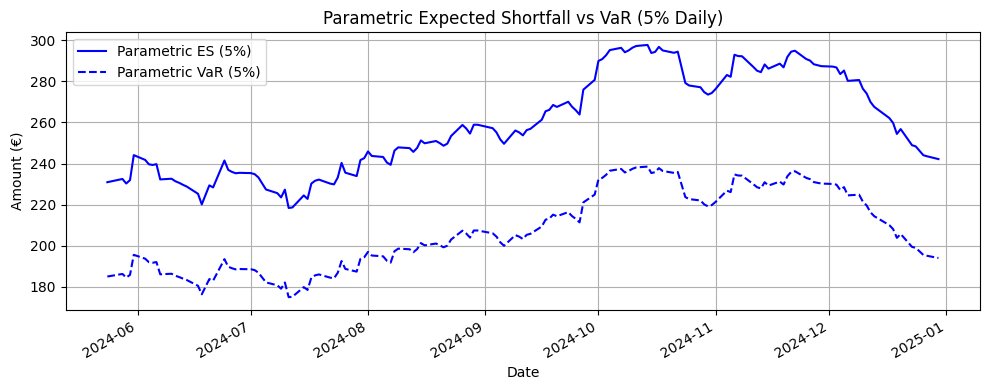

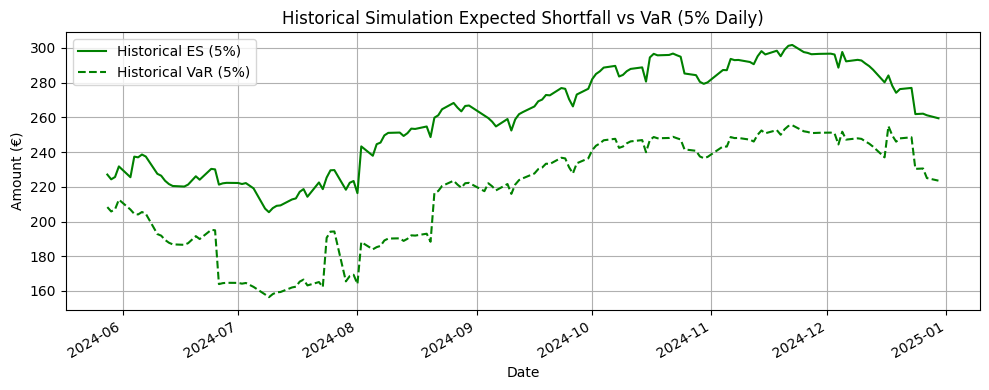

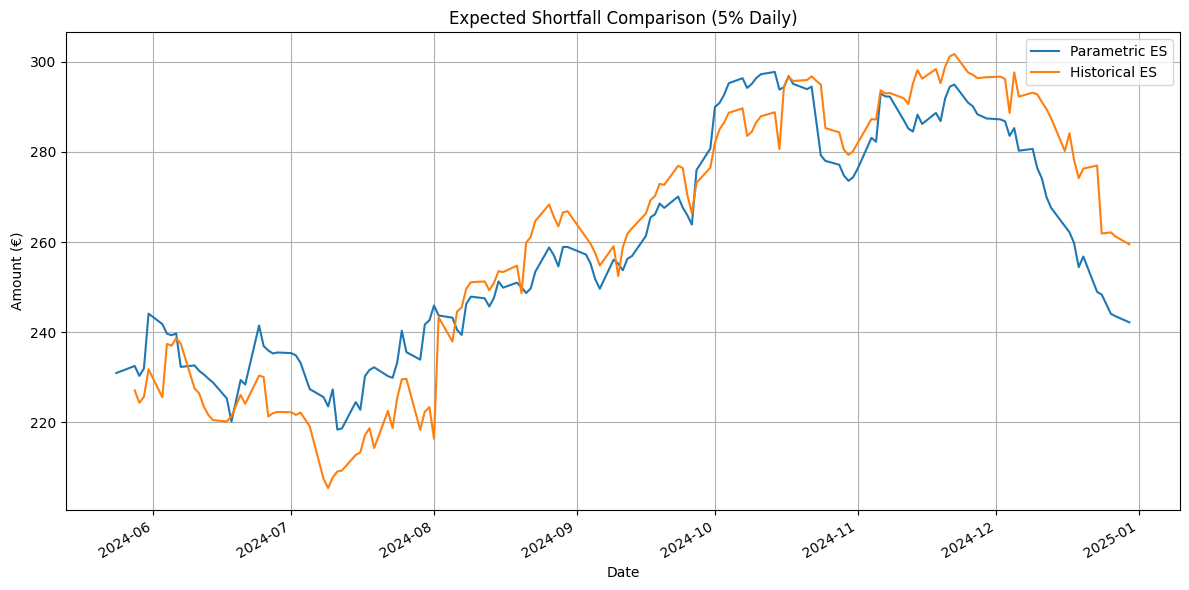

--- Expected Shortfall Comparison (5% quantile) ---
Average Parametric ES: €259.28
Average Historical ES: €260.36
Ratio (Historical/Parametric): 1.00x


In [74]:
# Constants
z_5pct = 1.65  # 5% quantile of standard normal
z_ES_5pct = 2.06  # Expected value beyond the 5% threshold for standard normal

# 1. Parametric Expected Shortfall using SMA volatility
es_sma = z_ES_5pct * sma_vol * portfolio_value
var_sma_5pct = z_5pct * sma_vol * portfolio_value  # For comparison

# Plot parametric ES
plt.figure(figsize=(10,4))
es_sma.dropna().plot(color='blue', label='Parametric ES (5%)')
var_sma_5pct.dropna().plot(color='blue', linestyle='--', label='Parametric VaR (5%)')
plt.title('Parametric Expected Shortfall vs VaR (5% Daily)')
plt.ylabel('Amount (€)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Non-parametric Expected Shortfall using Historical Simulation
hs_es = []
var_5pct_values = []
alpha = 0.05

for t in range(window, len(returns)):
    sample = returns['Portfolio'].iloc[t-window:t]
    sorted_returns = np.sort(sample)
    
    # Calculate VaR at 5%
    cutoff_index = int(alpha * len(sorted_returns))
    var_5pct = -sorted_returns[cutoff_index]
    var_5pct_values.append(var_5pct * portfolio_value.iloc[t])
    
    # Calculate ES as average of returns beyond VaR
    es = -sorted_returns[:cutoff_index+1].mean()
    hs_es.append(es * portfolio_value.iloc[t])

hs_es = pd.Series(hs_es, index=returns.index[window:])
hs_var_5pct = pd.Series(var_5pct_values, index=returns.index[window:])

# Plot historical simulation ES
plt.figure(figsize=(10,4))
hs_es.plot(color='green', label='Historical ES (5%)')
hs_var_5pct.plot(color='green', linestyle='--', label='Historical VaR (5%)')
plt.title('Historical Simulation Expected Shortfall vs VaR (5% Daily)')
plt.ylabel('Amount (€)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Compare both approaches
plt.figure(figsize=(12,6))
es_sma.dropna().plot(label='Parametric ES')
hs_es.plot(label='Historical ES')
plt.title('Expected Shortfall Comparison (5% Daily)')
plt.ylabel('Amount (€)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary statistics
print("--- Expected Shortfall Comparison (5% quantile) ---")
print(f"Average Parametric ES: €{es_sma.dropna().mean():.2f}")
print(f"Average Historical ES: €{hs_es.mean():.2f}")
print(f"Ratio (Historical/Parametric): {hs_es.mean() / es_sma.dropna().mean():.2f}x")

**Interpretation:**


---


**Parametric ES:** Provides a smooth estimate of tail risk that closely tracks volatility changes.
It is always higher than its corresponding VaR (dashed line), showing that the expected loss when VaR is breached is significantly higher than the VaR itself.
Like parametric VaR, this approach responds gradually to changes in market conditions.
The ratio of ES to VaR is constant (2.06/1.65 ≈ 1.25) due to the normal distribution assumption.

**Historical ES:** Tends to be more reactive to extreme returns entering or leaving the rolling window.
It shows more pronounced spikes when severe losses occur, as these directly affect the empirical tail average.
Unlike the parametric approach, the ratio of historical ES to historical VaR is not constant and varies based on the empirical distribution of returns.
The historical ES can better capture fat-tailed behavior if present in the return data